Import library

# Bagian Baru

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import tensorflow as tf
import keras
import cv2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Load Data set

In [31]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Tubes alexnet/Train_Data_Tubes'
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(227,227),
    batch_size=32
)

print("\nKelas yang terdeteksi:")
print(data.class_names)

class_names = data.class_names
img_size = 227
batch = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

total_count = len(dataset)

train_count = int(total_count * 0.8)
val_count = int(total_count * 0.1)
test_count = total_count - train_count - val_count

print("\nPembagian Dataset:")
print("Total Images (Batches): ", total_count)
print("Train Images (Batches): ", train_count)
print("Validation Images (Batches): ", val_count)
print("Test Images (Batches): ", test_count)

train_ds = dataset.take(train_count)
remaining_ds = dataset.skip(train_count)
val_ds = remaining_ds.take(val_count)
test_ds = remaining_ds.skip(val_count)

Tuner = tf.data.AUTOTUNE
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)


Found 300 files belonging to 3 classes.

Kelas yang terdeteksi:
['Beras', 'Gandum', 'Sorgum']
Found 300 files belonging to 3 classes.

Pembagian Dataset:
Total Images (Batches):  10
Train Images (Batches):  8
Validation Images (Batches):  1
Test Images (Batches):  1


Augmentasi

In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [34]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)


(32, 227, 227, 3)


In [35]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)


img_size = 227

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

**AlexNet**

In [36]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def alexnet(input_shape, n_classes):

    input = Input(input_shape)
    x = Conv2D(96, 11, strides=4, activation='relu', padding='valid')(input)
    x = MaxPool2D(3, strides=2)(x)
    x = Conv2D(256, 5, activation='relu', padding='same')(x)
    x = MaxPool2D(3, strides=2)(x)
    x = Conv2D(384, 3, activation='relu', padding='same')(x)
    x = Conv2D(384, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = MaxPool2D(3, strides=2)(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    return model

input_shape = (227, 227, 3)
n_classes = len(class_names)

K.clear_session()
model = alexnet(input_shape, n_classes)

initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nArsitektur Model: ")
model.summary()



Arsitektur Model: 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,293,635 (222.37 MB)

 Trainable params: 58,293,635 (222.37 MB)

 Non-trainable params: 0 (0.00 B)

training

In [37]:
print("\nMemulai proses training...")

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               mode='max')

epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)



Memulai proses training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - accuracy: 0.3625 - loss: 1023.7187 - val_accuracy: 0.3182 - val_loss: 1.1404
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.3572 - loss: 1.1539 - val_accuracy: 0.3182 - val_loss: 1.1333
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.3449 - loss: 1.1353 - val_accuracy: 0.3182 - val_loss: 1.1130
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.3058 - loss: 1.1094 - val_accuracy: 0.3636 - val_loss: 1.1014
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.3337 - loss: 1.1023 - val_accuracy: 0.3864 - val_loss: 1.0916
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.3871 - loss: 1.0968 - val_accuracy: 0.3864 - val_loss: 1.0881
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.3215 - loss: 1.0887 - val_accuracy: 0.3636 - val_loss: 1.0816
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.4089 - loss: 1.0808 - val_accuracy: 0.4

graph accuracy

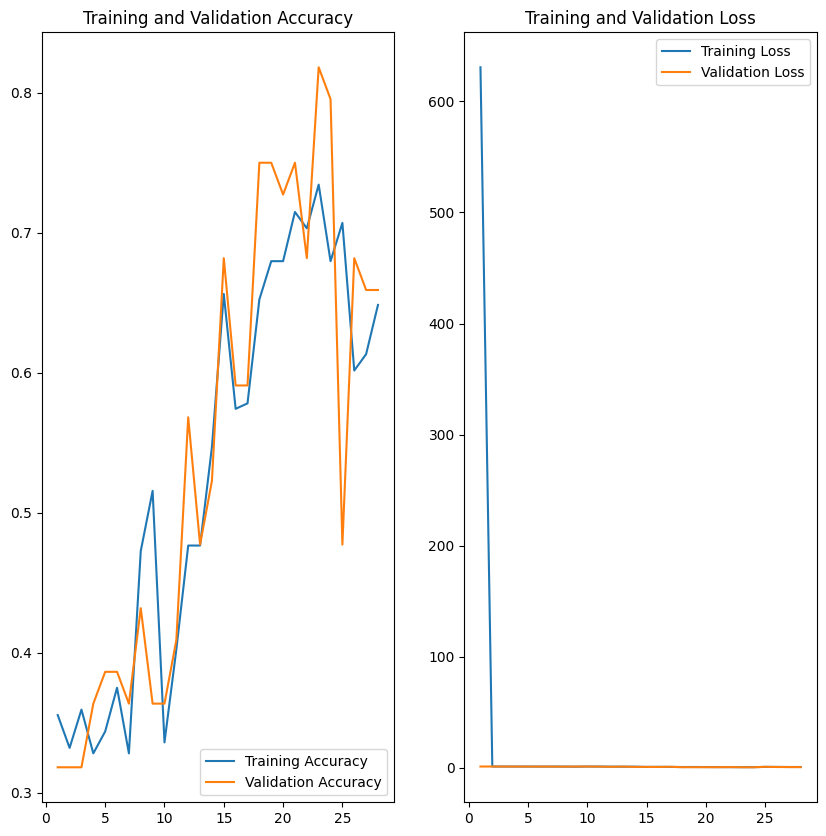

In [38]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
model.save('/content/drive/MyDrive/alexnet_model.h5')

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/alexnet_model.h5'
model = load_model(model_path)

class_names = ['Beras', 'Gandum', 'Sorgum']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(227, 227))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  # Add batch dimension

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images('/content/drive/MyDrive/Colab Notebooks/Tubes alexnet/Test_data_tubes/Beras/Beras 1.jpg', save_path='/content/drive/MyDrive/beras.jpg')
print(result)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Prediksi: Beras
Confidence: 54.98%
Prediksi: Beras dengan confidence 54.98%. Gambar asli disimpan di /content/drive/MyDrive/beras.jpg.
